In [28]:
# Install required packages
%pip install matplotlib numpy pandas torch


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Graph Attention Auto-Encoders

preset parameter

In [33]:
dataset = "dataset2"
lnc_mi = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_mi.csv', index_col='0').values
mi_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/mi_di.csv', index_col='0').values
lnc_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_di.csv', index_col='0').values
L_num = lnc_mi.shape[0]
D_num = mi_di.shape[1]
M_num = mi_di.shape[0]
print(f"{L_num} --- {D_num} --- {M_num}")

665 --- 316 --- 295


In [34]:
A = np.load('./our_dataset/' + dataset + '/A/A_1_1.npy')
folds = 5
in_dimension = A.shape[1]
embedding_dimension = 128
learn_rate = 1e-4
weight_decay = 1e-5
n_epochs = 100
network_num = 4
hidden_dimension = []
lambda_param = 1

train

In [35]:
print("Start training GATE")
rds = []
res = []
for fold in range(folds):
    d = []
    e = []
    for i in range(network_num):
        epoch = 0
        # A = torch.Tensor(np.load('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1) + '.npy'))
        A_numpy = np.load('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1) + '.npy')
        
        # Tạo ma trận đặc trưng (dense tensor) để làm input features
        # Đổi tên A -> A_features để code rõ ràng hơn
        A_features = torch.Tensor(A_numpy)

        edge_indices = torch.from_numpy(np.vstack(A_numpy.nonzero()))
        edge_values = torch.ones(edge_indices.shape[1], dtype=torch.float32)
        # Tạo sparse tensor ban đầu (có thể chưa được hợp nhất)
        A_sparse_uncoalesced = torch.sparse_coo_tensor(edge_indices, edge_values, A_features.shape)

        # Hợp nhất và sắp xếp lại tensor -> Đây là tensor bạn sẽ sử dụng
        A_sparse = A_sparse_uncoalesced.coalesce()
        source_nodes_indices = edge_indices[0] # Nút nguồn (S)
        target_nodes_indices = edge_indices[1] # Nút đích (R)


        # Thay đổi 1: Sử dụng mô hình VGAE thay vì GraphConvolution
        model = GATE(in_dimension, hidden_dimension, embedding_dimension) # <--- THAY ĐỔI
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
    

        while epoch < n_epochs:
            model.train()
            optimizer.zero_grad()
        

            reconstructed_A, final_embeddings = model(A_sparse, A_features)
            
            # Thay đổi 4: Sử dụng hàm loss của GATE
            loss = gate_loss_function(reconstructed_A, A_features, final_embeddings, 
                                      target_nodes_indices, source_nodes_indices, lambda_param)
            
            loss.backward()
            optimizer.step()
            epoch += 1
            
        model.eval()
        with torch.no_grad():
            # Forward pass khi eval cũng trả về 3 giá trị
            rd, re = model(A_sparse, A_features) # <--- THAY ĐỔI
            d.append(rd)
            
            # Thay đổi 5: Lưu 'mu' làm vector biểu diễn tiềm ẩn
            e.append(re) # <--- THAY ĐỔI (thay 're' bằng 'mu')
            
        # Tên biến loss đã được cập nhật ở trên
        print(f"The layer {fold + 1} variational graph auto-encoder loss is {loss.detach().cpu().item()}")
    
    res.append(e)
    rds.append(d)

Start training GATE


The layer 1 variational graph auto-encoder loss is 283.019775390625
The layer 1 variational graph auto-encoder loss is 365.7242736816406
The layer 1 variational graph auto-encoder loss is 376.6512756347656
The layer 1 variational graph auto-encoder loss is 376.8013610839844
The layer 2 variational graph auto-encoder loss is 288.45697021484375
The layer 2 variational graph auto-encoder loss is 361.6031494140625
The layer 2 variational graph auto-encoder loss is 369.8015441894531
The layer 2 variational graph auto-encoder loss is 372.0838317871094
The layer 3 variational graph auto-encoder loss is 285.89105224609375
The layer 3 variational graph auto-encoder loss is 419.9143371582031
The layer 3 variational graph auto-encoder loss is 422.1340026855469
The layer 3 variational graph auto-encoder loss is 436.48345947265625
The layer 4 variational graph auto-encoder loss is 288.2109375
The layer 4 variational graph auto-encoder loss is 371.69390869140625
The layer 4 variational graph auto-en

Save the results

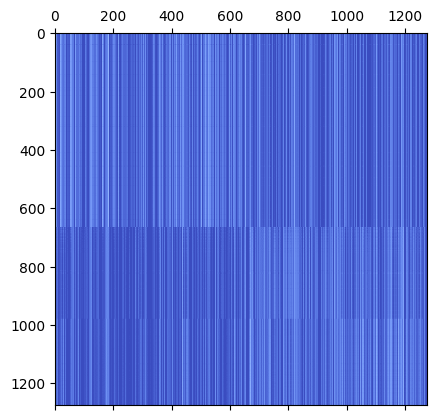

In [36]:
import os

output_dir = './our_dataset/' + dataset + '/A_gate_encoder'
os.makedirs(output_dir, exist_ok=True)

for fold in range(folds):
    for i in range(network_num):
        file_path = os.path.join(output_dir, f'A_{fold + 1}_{i + 1}.npy')
        np.save(file_path, res[fold][i].detach().numpy())

plt.matshow(rds[0][0].detach().numpy(), cmap=plt.cm.coolwarm, vmin=0, vmax=1)